In [1]:
import math
import torch

import numpy as np
import gpytorch
from gpytorch.kernels import RBFKernel
from ntwrk.bayesopt import BayesOpt
import matplotlib.pyplot as plt

In [2]:
def true_func(x, noise=0.02):
    return -torch.sin(3 * (x-1.)) - (x - 1.).pow(2) + 0.7 * (x-1.) + noise * torch.randn(x.shape)

In [3]:
x = torch.linspace(0, 3)
y = true_func(x, noise=0)

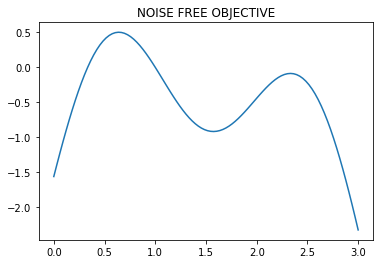

In [4]:
plt.plot(x, y)
plt.title("NOISE FREE OBJECTIVE")
plt.show()

In [5]:
def expected_improvement(bayesopt, test_points, explore=0.01):
    bayesopt.surrogate.train()
    mu_sample = bayesopt.surrogate(bayesopt.train_x).mean
    current_max, max_ind = mu_sample.max(0)

    bayesopt.surrogate.eval()
    bayesopt.surrogate_lh.eval()
    pred_dist = bayesopt.surrogate_lh(bayesopt.surrogate(test_points))
    mu_test = pred_dist.mean
    var_test = pred_dist.variance
    
    
    imp = mu_test - current_max - explore
    z = imp.div(var_test)
    std_normal = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

    ei = imp * std_normal.cdf(z) + var_test * std_normal.log_prob(z).exp()
    ei[var_test == 0.] = 0.
    
    return ei

In [6]:
max_x = 3.

rate = torch.rand(1) * max_x
rwrd = true_func(rate)


bo = BayesOpt(rate, rwrd, max_x=max_x)


In [7]:
rate

tensor([1.4104])

In [8]:
bo.surrogate_lh.eval();
bo.surrogate.eval();

test_points = torch.linspace(0, 3., 200).float()
test_dist = bo.surrogate_lh(bo.surrogate(test_points))

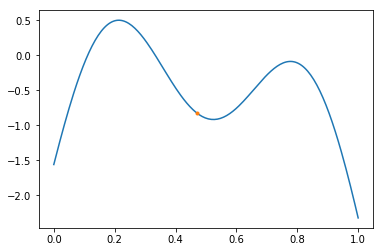

In [9]:
plt.plot(test_points.div(max_x), true_func(test_points, 0.).detach())
plt.plot(bo.train_x, bo.train_y, marker='.', linestyle="None")
plt.show()

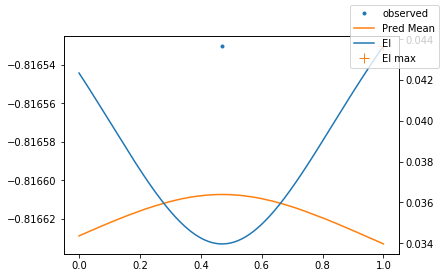

before update: 
torch.Size([1, 1])
after update: 
torch.Size([2, 1])


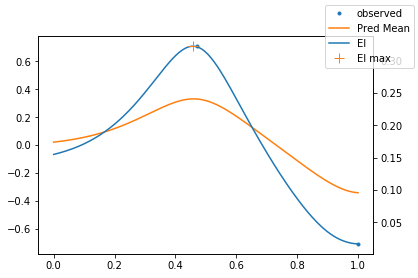

before update: 
torch.Size([2, 1])
after update: 
torch.Size([3, 1])


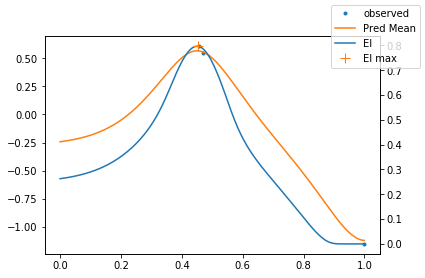

before update: 
torch.Size([3, 1])
after update: 
torch.Size([4, 1])


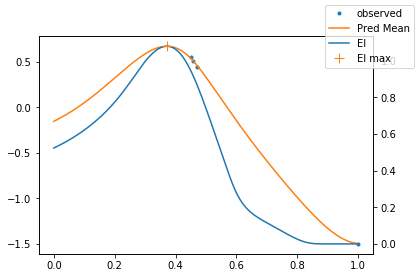

before update: 
torch.Size([4, 1])
after update: 
torch.Size([5, 1])


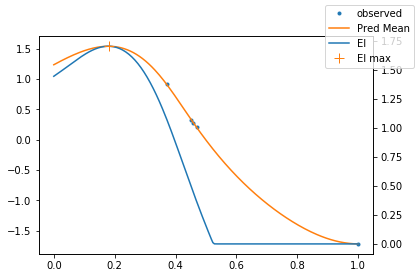

before update: 
torch.Size([5, 1])
after update: 
torch.Size([6, 1])


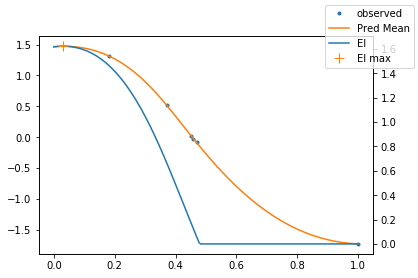

before update: 
torch.Size([6, 1])
after update: 
torch.Size([7, 1])


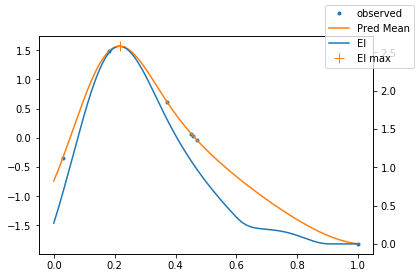

before update: 
torch.Size([7, 1])
after update: 
torch.Size([8, 1])


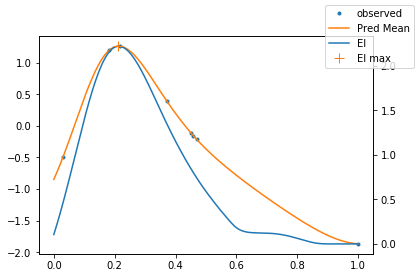

before update: 
torch.Size([8, 1])
after update: 
torch.Size([9, 1])


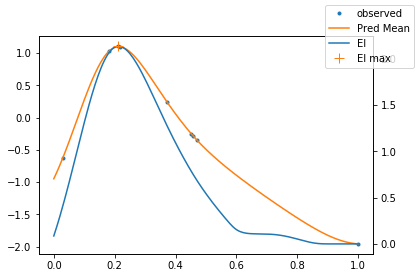

before update: 
torch.Size([9, 1])
after update: 
torch.Size([10, 1])


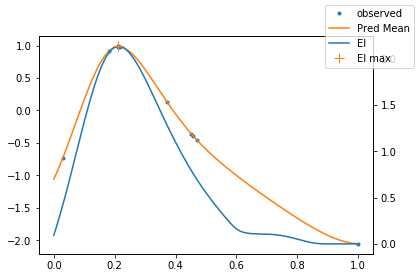

before update: 
torch.Size([10, 1])
after update: 
torch.Size([11, 1])


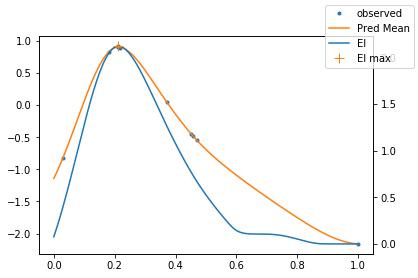

before update: 
torch.Size([11, 1])
after update: 
torch.Size([12, 1])


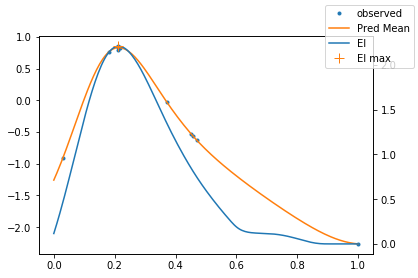

before update: 
torch.Size([12, 1])
after update: 
torch.Size([13, 1])


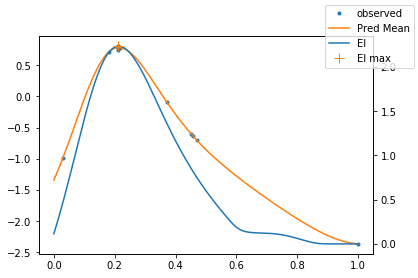

before update: 
torch.Size([13, 1])
after update: 
torch.Size([14, 1])


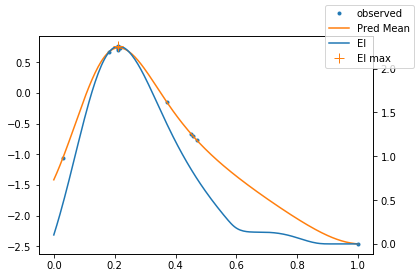

before update: 
torch.Size([14, 1])
after update: 
torch.Size([15, 1])


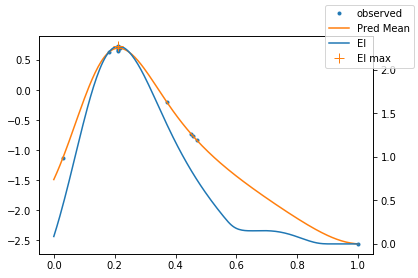

before update: 
torch.Size([15, 1])
after update: 
torch.Size([16, 1])


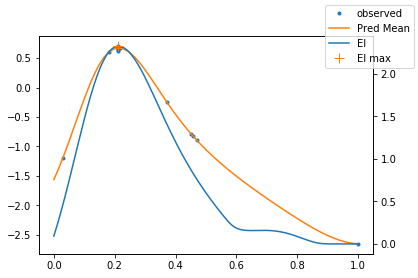

before update: 
torch.Size([16, 1])
after update: 
torch.Size([17, 1])


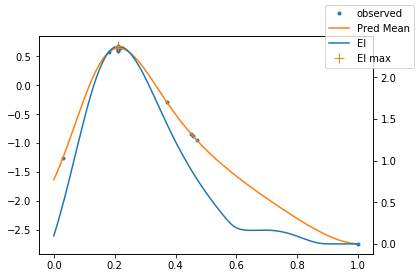

before update: 
torch.Size([17, 1])
after update: 
torch.Size([18, 1])


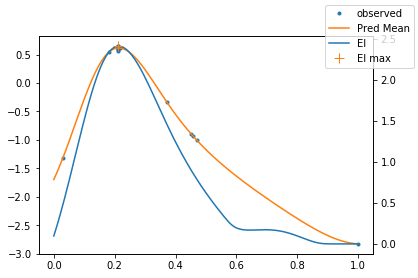

before update: 
torch.Size([18, 1])
after update: 
torch.Size([19, 1])


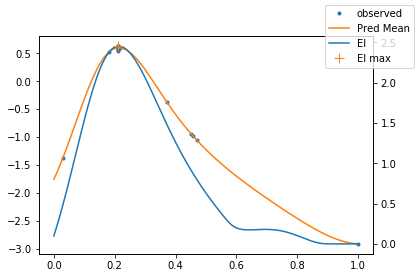

before update: 
torch.Size([19, 1])
after update: 
torch.Size([20, 1])


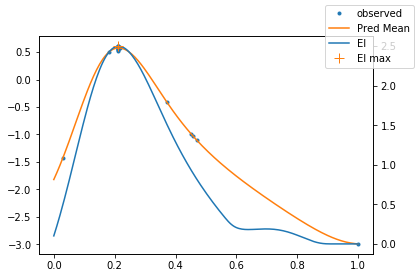

before update: 
torch.Size([20, 1])
after update: 
torch.Size([21, 1])


In [10]:
rnds = 20

for i in range(rnds):
    bo.train_surrogate(iters=200, overwrite=False)

    EI = expected_improvement(bo, test_points.div(max_x), explore=0.05)
    pred_mean = bo.surrogate_lh(bo.surrogate(test_points.div(max_x))).mean

    best_ac, ac_ind = EI.max(0)
    next_test = test_points[ac_ind]


    fig, ax1 = plt.subplots()
    ax1.plot(bo.train_x, bo.train_y.detach(),
             marker='.', linestyle="None", label="observed")
    ax1.plot(test_points.div(max_x), pred_mean.detach(), label="Pred Mean")
    ax2 = ax1.twinx()
    ax2.plot(test_points.div(max_x), EI.detach(),
             label="EI")
    ax2.plot(next_test.div(max_x), best_ac.detach(),
             label="EI max", marker="+", linestyle="None", markersize=10)
    fig.legend()
    plt.show()

    rwrd = true_func(next_test)
    bo.update_obs(next_test.unsqueeze(-1), rwrd.unsqueeze(-1))
    
#     print(bo.train_x, bo.train_y)

## Now Lets Try it With a Network

In [11]:
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import gym

In [12]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

In [13]:
max_x = 1000.

rate = torch.rand(1) * max_x
rwrd = torch.tensor(env.step(rate)[1]).unsqueeze(-1)

In [14]:
bo = BayesOpt(rate, rwrd, max_x=max_x)
print(bo.train_x, bo.train_y)

tensor([0.3511]) tensor([1.3419])


In [15]:
bo.surrogate_lh.eval();
bo.surrogate.eval();

test_points = torch.linspace(0, max_x, 200).float()
test_dist = bo.surrogate_lh(bo.surrogate(test_points))

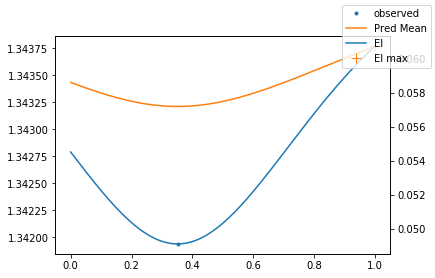

before update: 
torch.Size([1, 1])
after update: 
torch.Size([2, 1])
tensor([0.3511, 1.0000]) tensor([ 0.7071, -0.7071])


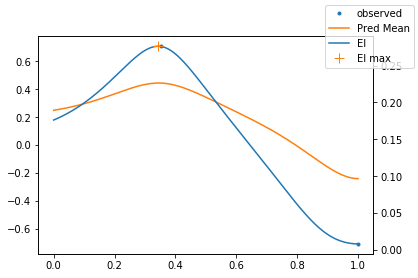

before update: 
torch.Size([2, 1])
after update: 
torch.Size([3, 1])
tensor([0.3511, 1.0000, 0.3417]) tensor([ 0.6803, -1.1482,  0.4679])


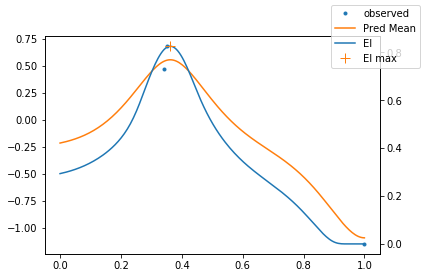

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([1.0000, 0.3417, 0.3618]) tensor([-1.1546,  0.5912,  0.5633])


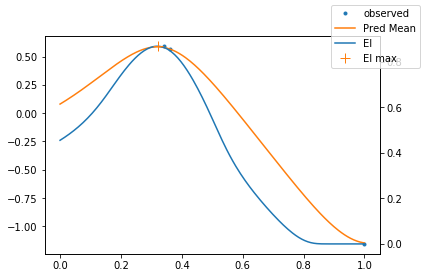

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.3417, 0.3618, 0.3216]) tensor([ 0.0198, -1.0097,  0.9900])


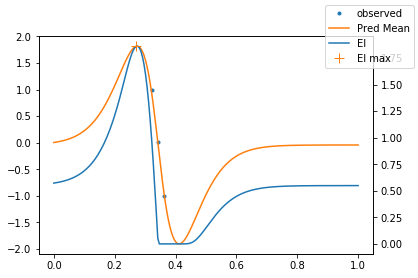

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.3618, 0.3216, 0.2714]) tensor([-0.9863, -0.0268,  1.0131])


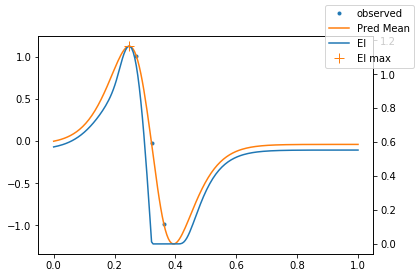

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.3216, 0.2714, 0.2462]) tensor([-1.1029,  0.2553,  0.8476])


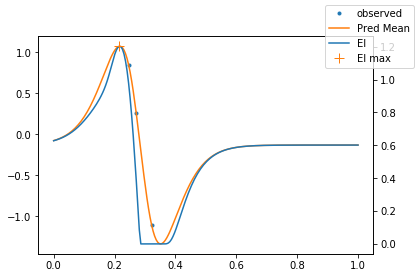

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.2714, 0.2462, 0.2161]) tensor([-0.9883, -0.0229,  1.0113])


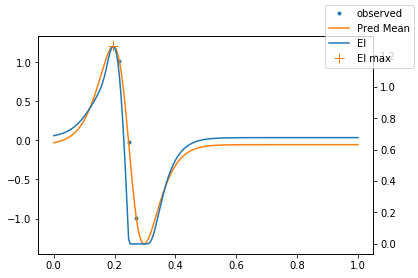

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.2462, 0.2161, 0.1960]) tensor([-1.0734,  0.1682,  0.9052])


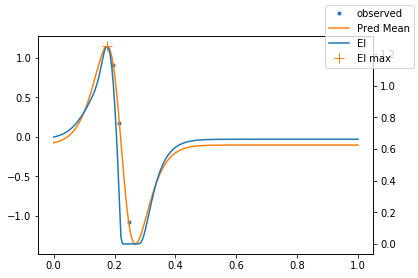

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.2161, 0.1960, 0.1759]) tensor([-1.0167,  0.0343,  0.9824])


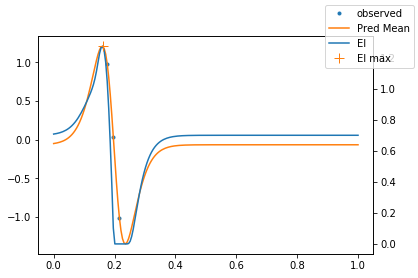

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1960, 0.1759, 0.1608]) tensor([-1.0574,  0.1270,  0.9304])


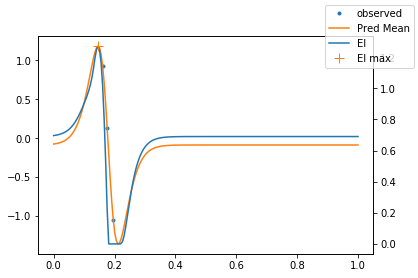

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1759, 0.1608, 0.1457]) tensor([-1.0153,  0.0314,  0.9839])


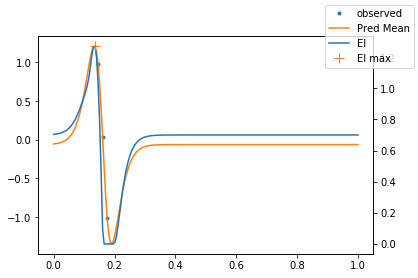

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1608, 0.1457, 0.1357]) tensor([-1.0701,  0.1592,  0.9108])


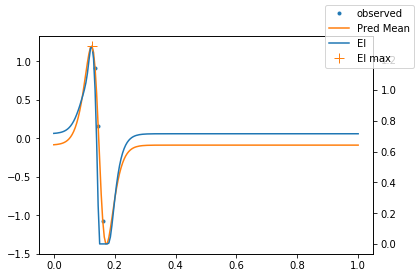

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1457, 0.1357, 0.1256]) tensor([-1.0122,  0.0248,  0.9874])


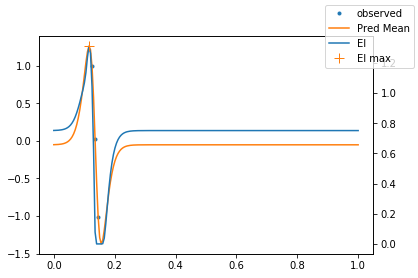

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1357, 0.1256, 0.1156]) tensor([-1.0132,  0.0269,  0.9863])


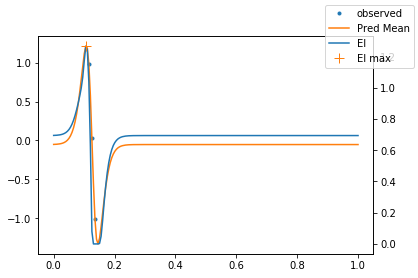

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1256, 0.1156, 0.1055]) tensor([-1.0144,  0.0295,  0.9849])


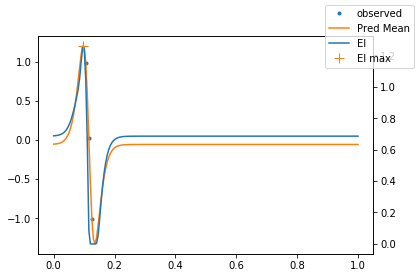

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1156, 0.1055, 0.0955]) tensor([-1.0157,  0.0323,  0.9835])


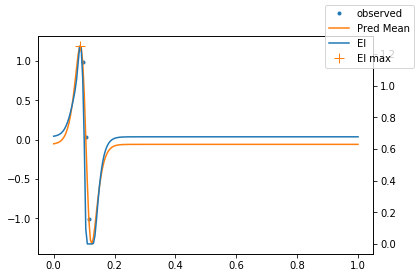

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.1055, 0.0955, 0.0854]) tensor([-1.0172,  0.0354,  0.9818])


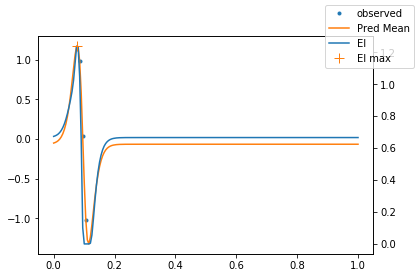

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.0955, 0.0854, 0.0754]) tensor([-1.0192,  0.0396,  0.9796])


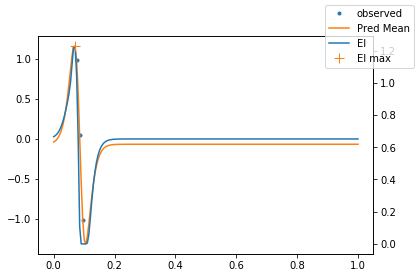

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.0854, 0.0754, 0.0704]) tensor([-1.1001,  0.2461,  0.8540])


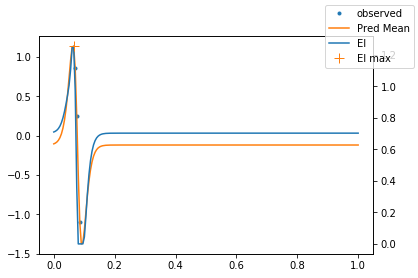

before update: 
torch.Size([3, 1])
after update: 
torch.Size([3, 1])
tensor([0.0754, 0.0704, 0.0653]) tensor([-1.0114,  0.0231,  0.9882])


In [16]:
rnds = 20
max_obs = 3
for i in range(rnds):
    bo.train_surrogate(iters=200, overwrite=False)

    EI = expected_improvement(bo, test_points.div(max_x), explore=0.)
    pred_mean = bo.surrogate_lh(bo.surrogate(test_points.div(max_x))).mean

    best_ac, ac_ind = EI.max(0)
    next_test = test_points[ac_ind]


    fig, ax1 = plt.subplots()
    ax1.plot(bo.train_x, bo.train_y.detach(),
             marker='.', linestyle="None", label="observed")
    ax1.plot(test_points.div(max_x), pred_mean.detach(), label="Pred Mean")
    ax2 = ax1.twinx()
    ax2.plot(test_points.div(max_x), EI.detach(),
             label="EI")
    ax2.plot(next_test.div(max_x), best_ac.detach(),
             label="EI max", marker="+", linestyle="None", markersize=10)
    fig.legend()
    plt.show()

    rwrd = true_func(next_test)
    bo.update_obs(next_test.unsqueeze(-1), rwrd.unsqueeze(-1), max_obs=max_obs)
    
#     if bo.train_x.numel() > max_obs:
# #         bo.update_obs(bo.train_x[-max_obs:], bo.train_y[-max_obs:])
#         bo.train_x = bo.train_x[-max_obs:]
#         bo.train_y = bo.train_y[-max_obs:]
#         bo.surrogate.set_train_data(bo.train_x, bo.train_y, strict=False)
    
    print(bo.train_x, bo.train_y)

In [17]:
tt = torch.arange(10)

In [18]:
tt[np.random.choice(10)]

tensor(6)